# Mixture of 2 Gaussians
Let's consider an example, where the likelihood is a mixture of two Gaussians with a common mean $\theta$, equal weights and different (fixed) variances:

$$f(x | \theta) = 0.5 * \mathcal{N}(x | \theta, 1) + 0.5 * \mathcal{N}(x | \theta, 0.01)$$

and the prior is uniform: $p(\theta) = \mathcal{U}(-10, 10)$

The posterior is then given as:

In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals

%matplotlib notebook

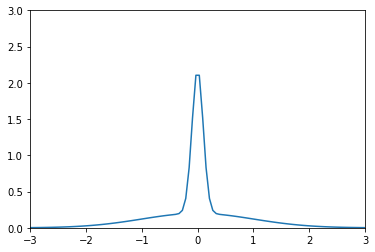

In [2]:
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In the ABC setting, drawing from the posterior, can be realized by sampling from the standard normal distribution and then using the following distance function:

In [3]:
prior = pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

def simulator(mu):
    return np.random.normal(mu, 1, size=100)

summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho

y0 = np.array([0.])

## Rejection-ABC

In [4]:
rej = pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0)

rej.sample(nr_samples=1000, threshold=0.025)

Rejection sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:     384000 - Acceptance rate: 0.002604 - Time:    14.96 s


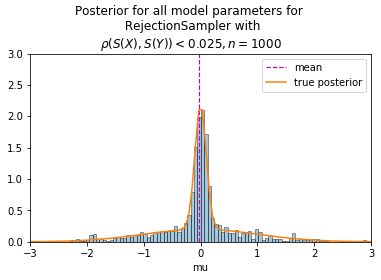

In [5]:
plot_marginals(rej, xlim=[(-3,3)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

## MCMC-ABC

In [6]:
mcmc = pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                         summaries=[summary], distance=rho,
                         observation=y0)
mcmc.sample(nr_samples=1_000, threshold=0.025, step_size=[0.15**2])

MCMC sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:      37661 - Acceptance rate: 0.026553 - Time:    26.60 s


<IPython.core.display.Javascript object>


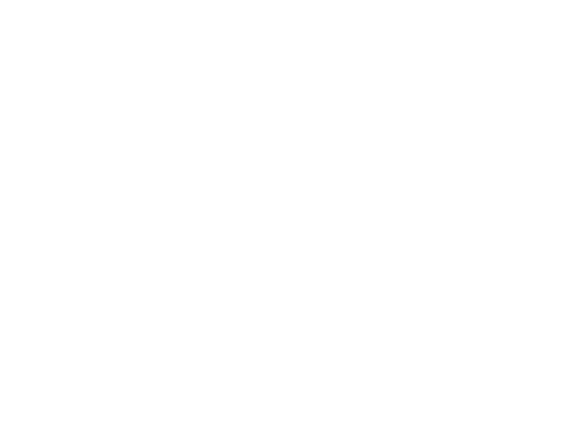

In [7]:
plot_marginals(mcmc, xlim=[(-3,3)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

# BOLFI

In [5]:
bolfi = pyabc.BOLFI(priors=[prior], simulator=simulator,
                 summaries=[summary], distance=rho,
                  observation=y0, domain=[(-10,10)],
                   acquisition='lcb')

bolfi.fit(initial_evidence_size=5, max_iter=50)

Starting Bayesian Optimization with initial evidence size = 5, max_iter = 50
Fitting BOLFI finished - Time:    70.12 s


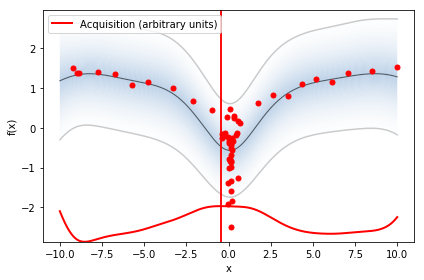

In [10]:
bolfi.optim.plot_acquisition()

In [6]:
bolfi.sample(nr_samples=1000, threshold=0.0025, n_chains=4, burn_in=100)

Approximating likelihood with threshold 0.0025
Obtaining 1000 MCMC sampling using approximate likelihood with 4 chains and 100 burn-in samples
Samples:   1004 - Acceptance rate: 0.821713


array([[ 0.49881109],
       [ 0.49881109],
       [ 0.37371805],
       ...,
       [-0.00759746],
       [ 0.04098968],
       [-0.26776123]])

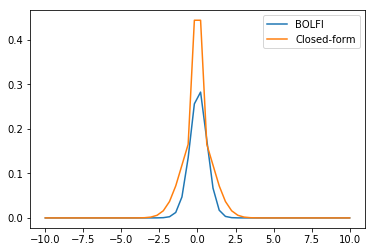

In [7]:
x = np.linspace(-10,10)[:,np.newaxis]
bolfi_post = bolfi.extract_posterior(threshold=0.0025)
plt.plot(x, bolfi_post(x) / np.sum(bolfi_post(x)), label='BOLFI')
plt.plot(x, posterior(x), label='Closed-form')
plt.legend()

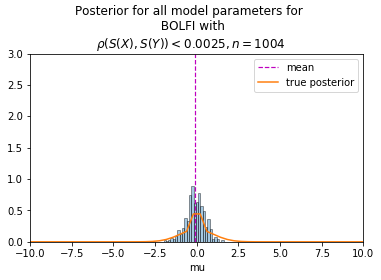

In [8]:
plot_marginals(bolfi, xlim=[(-10,10)], ylim=(0,3), kde=False)
plt.plot(x, posterior(x), label='true posterior')
plt.legend()

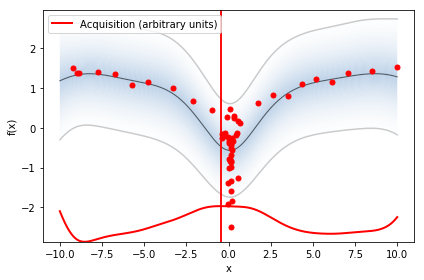

In [9]:
bolfi.optim.plot_acquisition()

In [47]:
bolfi.Thetas

array([[-8.44680041],
       [-1.9872614 ],
       [-3.22701727],
       ..., 
       [-0.24355277],
       [-3.3984626 ],
       [-4.28351256]])

# Using ELFI's BOLFI

In [14]:
import elfi

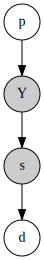

In [110]:
elfi.new_model()

p = elfi.Prior('uniform', -10, 20)

def sim(x, batch_size, random_state):
    return simulator(x)

Y = elfi.Simulator(sim, p, observed=y0)

def summ(x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho

s = elfi.Summary(summ, Y)

d = elfi.Distance('euclidean', s)

elfi.draw(d)

In [111]:
elfibolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10,
                   bounds={'p': (-10, 10)}, acq_noise_var=[0.1], seed=101)

In [113]:
post = elfibolfi.fit(n_evidence=200, threshold=0.00025)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9adf5636a0>], dtype=object)

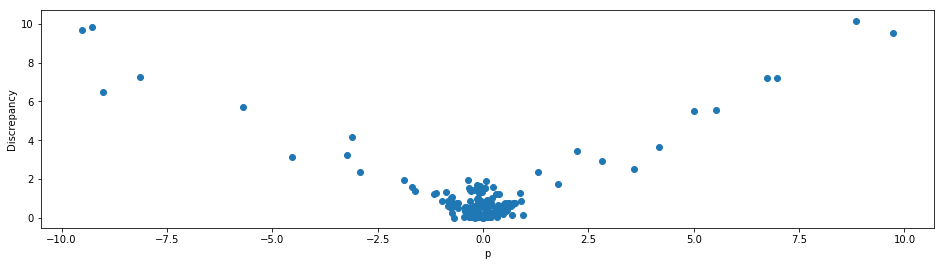

In [114]:
elfibolfi.plot_discrepancy()

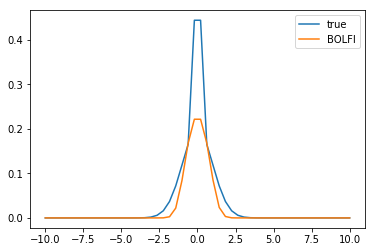

In [117]:
post = elfibolfi.extract_posterior()
plt.plot(x, post.pdf(x) / np.sum(post.pdf(x)), label='BOLFI')
plt.plot(x, posterior(x), label='true')
plt.legend()

In [118]:
result_BOLFI = elfibolfi.sample(1000, info_freq=1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
p 2045.21231422 0.9995313299


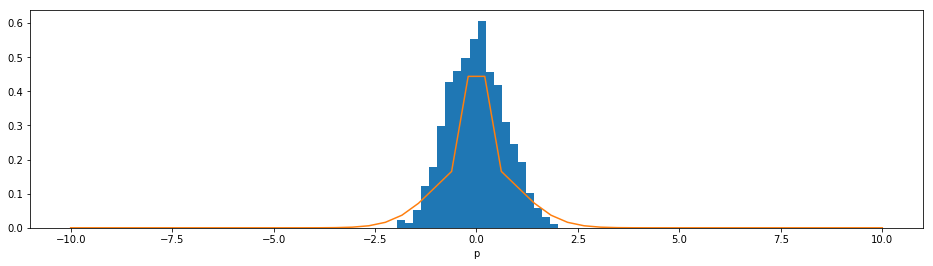

In [119]:
result_BOLFI.plot_marginals(normed=True)
plt.plot(x, posterior(x))
